<a href="https://colab.research.google.com/github/jesminmousumy/Python-Programming/blob/main/Real_World_Data_Analytics_Project_E_Commerce_Customer_Retention_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Step 1:Data Collection & Cleaning
#import Some libraries
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('Online Retail.csv')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
# Check for missing values
print(df.isnull().sum())

InvoiceNo          0
StockCode          1
Description      302
Quantity           1
InvoiceDate        1
UnitPrice          1
CustomerID     35136
Country            1
dtype: int64


In [7]:
# Remove rows with missing CustomerID (critical for analysis)
df = df.dropna(subset=['CustomerID'])
# Handle negative quantities (cancellations)
df = df[df['Quantity'] > 0]

# Remove duplicates
df = df.drop_duplicates()

# Calculate total sales (Quantity * UnitPrice)
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

# Verify cleaned data
print(df.describe())

           Quantity     UnitPrice    CustomerID    TotalSales
count  63614.000000  63614.000000  63614.000000  63614.000000
mean      14.134797      3.158394  15359.946505     24.170625
std      298.469953      5.347742   1770.567058    316.901014
min        1.000000      0.000000  12346.000000      0.000000
25%        2.000000      1.250000  13893.000000      5.040000
50%        5.000000      1.950000  15311.000000     12.500000
75%       12.000000      3.750000  17019.000000     19.800000
max    74215.000000    320.690000  18283.000000  77183.600000


<ipython-input-8-be29ee14af33>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.resample('M', on='InvoiceDate')['TotalSales'].sum()


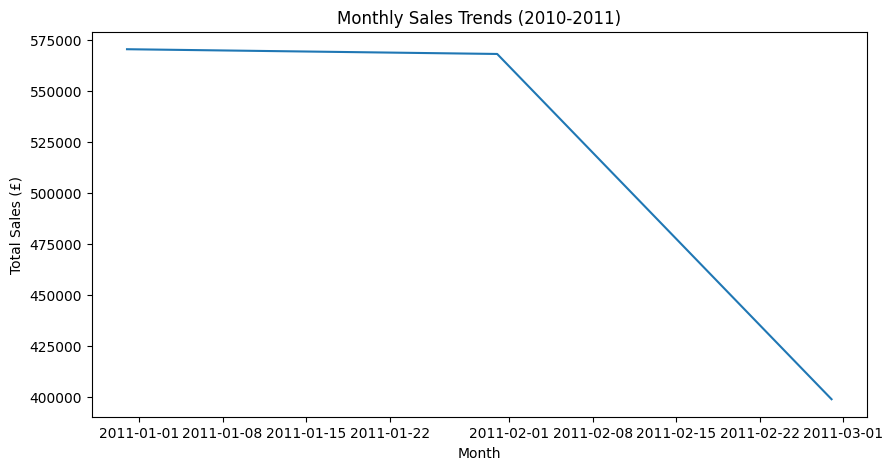

In [8]:
# Step 2: Exploratory Data Analysis (EDA) Key Metrics & Visualizations
# import some libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Sales trends over time
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
monthly_sales = df.resample('M', on='InvoiceDate')['TotalSales'].sum()
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales)
plt.title("Monthly Sales Trends (2010-2011)")
plt.xlabel("Month")
plt.ylabel("Total Sales (£)")
plt.show()

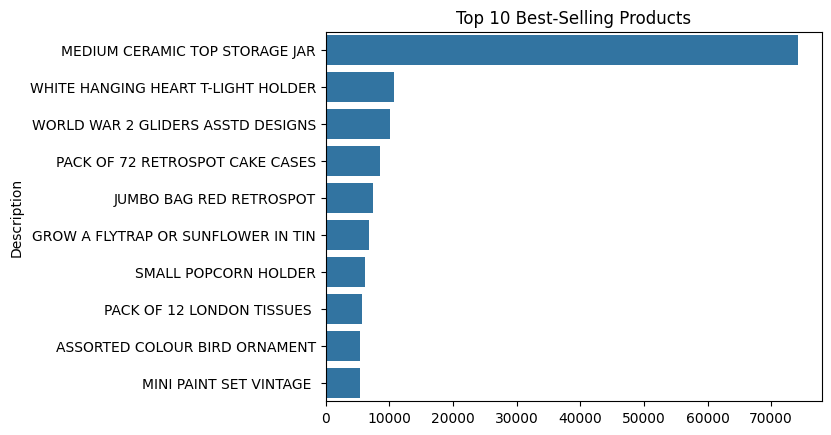

In [9]:
# Top-selling products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 10 Best-Selling Products")
plt.show()

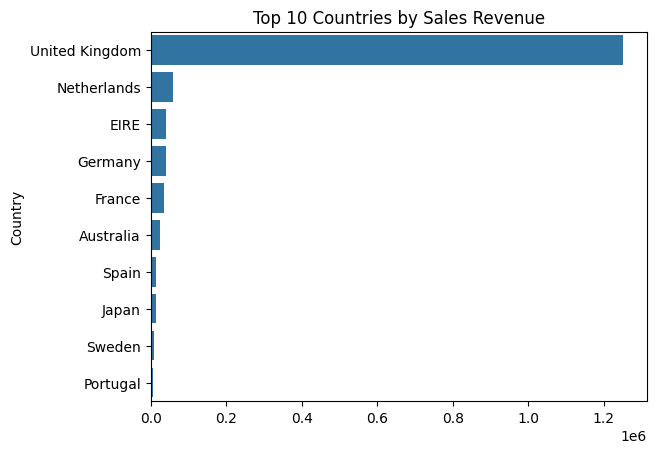

In [10]:
# Customer demographics (by country)
country_sales = df.groupby('Country')['TotalSales'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=country_sales.values, y=country_sales.index)
plt.title("Top 10 Countries by Sales Revenue")
plt.show()

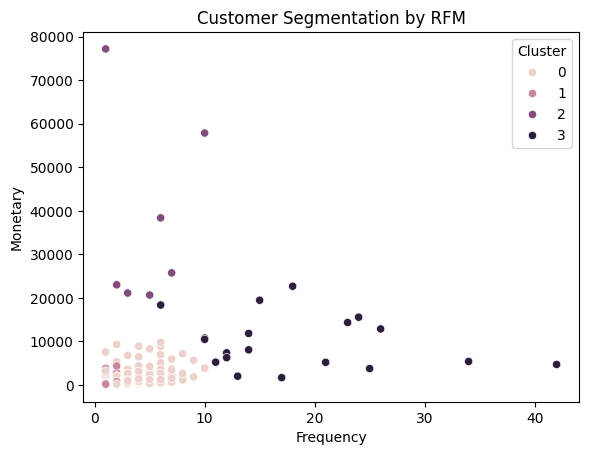

In [13]:
# Step 3. Customer Segmentation (RFM Analysis & K-Means Clustering)
#import some libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# RFM Calculation
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalSales': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSales': 'Monetary'
})

# Normalize & apply K-Means clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize clusters
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster')
plt.title("Customer Segmentation by RFM")
plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfve0797y/rh2ioce3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfve0797y/37oqo_zz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77545', 'data', 'file=/tmp/tmpfve0797y/rh2ioce3.json', 'init=/tmp/tmpfve0797y/37oqo_zz.json', 'output', 'file=/tmp/tmpfve0797y/prophet_modelev5jscnh/prophet_model-20250411191617.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:16:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:16:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


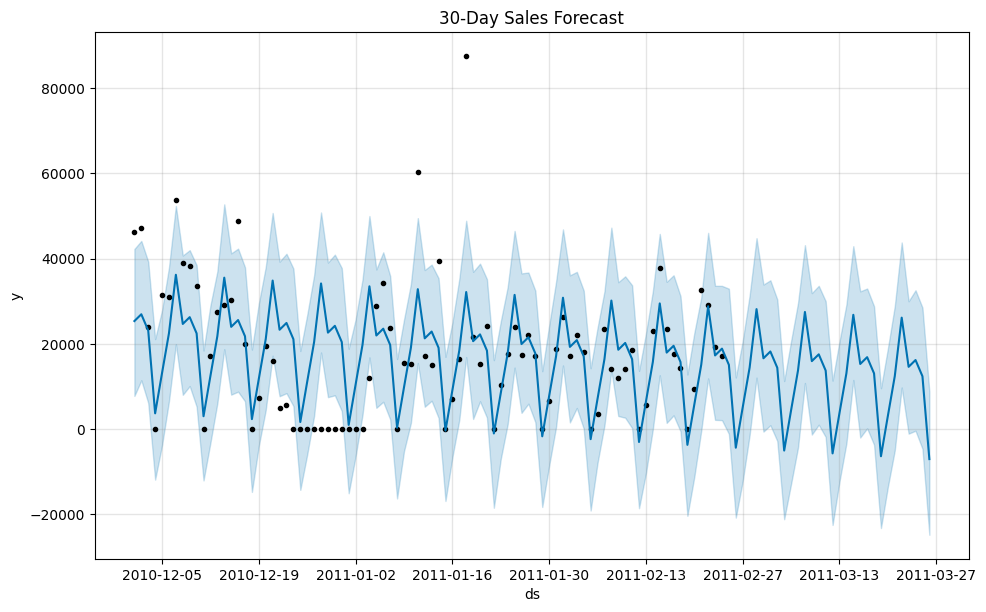

In [14]:
# Step 4: Sales Forecasting (Time-Series with Prophet)
from prophet import Prophet

# Prepare daily sales data
daily_sales = df.resample('D', on='InvoiceDate')['TotalSales'].sum().reset_index()
daily_sales.columns = ['ds', 'y']

# Fit Prophet model
model = Prophet()
model.fit(daily_sales)

# Forecast next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title("30-Day Sales Forecast")
plt.show()